# Imports

In [15]:
%load_ext autoreload

import pandas
import numpy
import os
import random

import matplotlib.pyplot as plt
%matplotlib inline

image_output_directory = os.path.abspath("../Datasets/Pokemon/SquareImages")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Loading stats from CSV file

In [13]:
csv_file = "../Datasets/Pokemon/pokemon_alopez247.csv"
with open(csv_file, 'r') as f:
    statistics = pandas.read_csv(f)
# print(statistics.columns.values)

pokemon_names = list(statistics["Name"])
cat_to_label = {cat:i for i,cat in enumerate(pokemon_names)}
label_to_cat = {i:cat for i,cat in enumerate(pokemon_names)}

pokemon_subset = list(statistics[statistics["Generation"]==1]["Name"])
print("Pokemons : "+str(len(pokemon_subset)))

Pokemons : 151


# Preparing the dataset

In [16]:
training_images = []
training_labels = []
testing_images = []
testing_labels = []

for pokemon in pokemon_subset:
    directory = image_output_directory + "/" + pokemon + "/"
    files = [f for f in os.listdir(directory) if f.endswith("jpg") or f.endswith("png")]
    random.shuffle(files)
    
    num_files = len(files)
    num_training_files = int(numpy.floor(num_files * 0.9))
    training_files = files[:num_training_files]
    testing_files = files[num_training_files:]
    
    training_images += [os.path.abspath(directory+f) for f in training_files]
    training_labels += [cat_to_label[pokemon] for f in training_files]
    
    testing_images += [os.path.abspath(directory+f) for f in testing_files]
    testing_labels += [cat_to_label[pokemon] for f in testing_files]

    
print("Number of training files in total : "+str(len(training_images)))
print("Number of testing files in total : "+str(len(testing_images)))

Number of training files in total : 27543
Number of testing files in total : 3159


In [37]:
%autoreload 2
import data_processing as DP

# Shuffling train images
perm = numpy.random.permutation(len(training_images))
shuffled_train_images = numpy.array(training_images)[perm]
shuffled_train_labels = numpy.array(training_labels)[perm]
shuffled_train_categories = [label_to_cat[l] for l in shuffled_train_labels]

perm = numpy.random.permutation(len(testing_images))
shuffled_test_images = numpy.array(testing_images)[perm]
shuffled_test_labels = numpy.array(testing_labels)[perm]
shuffled_test_categories = [label_to_cat[l] for l in shuffled_test_labels]

train_examples = DP.get_image_tensors(
    shuffled_train_images, shuffled_train_labels, shuffled_train_categories, 32, 
    "../Datasets/Pokemon/train_tensors.pkl", image_output_directory
    )

test_examples = DP.get_image_tensors(
    shuffled_test_images, shuffled_test_labels, shuffled_test_categories, 32,
    "../Datasets/Pokemon/test_tensors.pkl", image_output_directory
    )

# Loading examples from file

In [68]:
%autoreload 2
import classification as CL

max_class = 15

training_examples = pandas.read_pickle("../Datasets/Pokemon/train_tensors.pkl")
train_selection = training_examples["Labels"] < max_class

testing_examples = pandas.read_pickle("../Datasets/Pokemon/test_tensors.pkl")
test_selection = testing_examples["Labels"] < max_class

X_train = training_examples["X"][train_selection]
Y_train = training_examples["Labels"][train_selection]
print("X_train : " +str(X_train.shape))
print("Y_train : " +str(Y_train.shape))

X_test = testing_examples["X"][test_selection]
Y_test = testing_examples["Labels"][test_selection]
print("X_test : " +str(X_test.shape))
print("Y_test : " +str(Y_test.shape))

# We normalize the data.
X_train = X_train / 255 
X_test = X_test / 255 
# X_train, X_test = CL.normalizing_features(X_train, X_test)

X_train : (2749, 32, 32, 3)
Y_train : (2749,)
X_test : (315, 32, 32, 3)
Y_test : (315,)


## One hot matrix from training labels

In [69]:
%autoreload 2
import classification as CL

# We convert labels into one-hot matrix
num_classes = int(numpy.max(Y_train)) + 1
Y_train_oh = numpy.transpose(CL.one_hot_matrix(Y_train, num_classes))
Y_test_oh = numpy.transpose(CL.one_hot_matrix(Y_test, num_classes))
print("Train One hot : "+str(Y_train_oh.shape))
print("Test One hot : "+str(Y_test_oh.shape))

Train One hot : (2749, 15)
Test One hot : (315, 15)


# Training a Convolutional Neural Network
Using Tensorflow

In [78]:
%autoreload 2
import cnn_classification as CNNC

rate = 0.001

train_acc, test_acc, parameters, costs = CNNC.model(
    X_train, Y_train_oh, X_test, Y_test_oh,
    learning_rate=rate, num_epochs=200
)

Cost after epoch 0: 2.810276
Cost after epoch 5: 2.679003
Cost after epoch 10: 2.422686
Cost after epoch 15: 2.297917
Cost after epoch 20: 2.184551
Cost after epoch 25: 2.097274
Cost after epoch 30: 2.039150
Cost after epoch 35: 1.980692
Cost after epoch 40: 1.946479
Cost after epoch 45: 1.917119
Cost after epoch 50: 1.887437
Cost after epoch 55: 1.867977
Cost after epoch 60: 1.844508
Cost after epoch 65: 1.825200
Cost after epoch 70: 1.808234
Cost after epoch 75: 1.794039
Cost after epoch 80: 1.775900
Cost after epoch 85: 1.766953
Cost after epoch 90: 1.750752
Cost after epoch 95: 1.734634
Cost after epoch 100: 1.726361
Cost after epoch 105: 1.714097
Cost after epoch 110: 1.705127
Cost after epoch 115: 1.691936
Cost after epoch 120: 1.686222
Cost after epoch 125: 1.674466
Cost after epoch 130: 1.666976
Cost after epoch 135: 1.664380
Cost after epoch 140: 1.643997
Cost after epoch 145: 1.641967
Cost after epoch 150: 1.625413
Cost after epoch 155: 1.626533
Cost after epoch 160: 1.616020

Train Accuracy: 0.079112664
Test Accuracy: 0.06837607


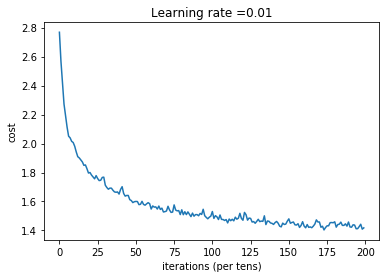

In [75]:
print("Train Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)

# plot the cost
plt.plot(numpy.squeeze(costs))
plt.ylabel('cost')
plt.xlabel('iterations (per tens)')
plt.title("Learning rate =" + str(rate))
plt.show()